# Explainable AI: Image explanation with LIME and PyTorch

Modern deep learning networks have achieved remarkable successes in a wide range of tasks such as image classification, and others.

While the performance of such a model is certainly impressive, it becomes more and more difficult to understand what the model does or which parts of an image are important for the model to base its decision on.

Generally, we have two ways of improving the interpretability of machine learning models: Either we build "white box" models that are inherently interpretable, or we use *post-hoc* methods. The latter take an opaque "black box" model and then derive which part of the input are particularly imporant for the model to arrive at a given classification.

In this example, we use the [LIME](https://github.com/marcotcr/lime) package as a *post-hoc* explanainer for a "black-box" image model.

We will use a few images from the [cats vs dogs](https://www.microsoft.com/en-us/download/details.aspx?id=54765) dataset. Since we only want to use a few images, we add some examples locally, to avoid downloading the full dataset (a GB or so) - but feel free to explore more.

We will use the pre-trained network model [Inception v3](https://pytorch.org/hub/pytorch_vision_inception_v3/) that was trained on the [ImageNet](https://www.image-net.org/) dataset.

In [ ]:
# a few sample images are in the repository - you can find the full dataset here:

#!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


In [ ]:
# if we download the file above...
# !unzip kagglecatsanddogs_5340.zip

The [ImageNet](https://www.image-net.org/) dataset consists of 1000 classes of various objects (such as, amonst others, cats and dogs).
A mapping of the class index to human-readable form can be found, for example, at [Google](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json).

In [1]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json

--2023-01-18 08:26:15--  https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.208, 172.217.18.16, 142.250.185.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2023-01-18 08:26:15 (2.62 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision as tv
from torchvision.models import inception_v3, Inception_V3_Weights

import matplotlib.pyplot as plt
import numpy as np
import os

import json

from PIL import Image

# import the LIME package
from lime import lime_image

# we need this later to visualize the areas that are relevant to the prediction
from skimage.segmentation import mark_boundaries



/home/kerzel/.cache/pypoetry/virtualenvs/datascienceintro-eVBNPtpL-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setups

First, we load the pre-trained [Inception v3](https://pytorch.org/hub/pytorch_vision_inception_v3/) model from the PyTorch repository.
We initialise the model with the publicly available weights.

Remember that this model has been trained on the ImageNet dataset, i.e. we need to make sure later that we bring our images to the right size and normalise them appropriately.

In [4]:
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/kerzel/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 103MB/s]  


Now we prepare the look-up table that maps the class index in the ImageNet data to a human readable format.
The file we have downloaded earlier is in [JSON](https://www.json.org/json-en.html) format and looks like this:
```
{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], ...
```
The number (represented as a string) is the class index, and then the element with index ```[1]``` is the name of the class.

In [5]:
index2label = []
with open('imagenet_class_index.json', 'r') as f:
    class_index = json.load(f)
    print('number of classes in ImageNet data {}'.format(len(class_index)))
    for i in range(len(class_index)):
      index2label.append(class_index[str(i)][1])  

#print a few labels
print(index2label[:5])

number of classes in ImageNet data 1000
['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']


Now we load our example image that we want to analyse.
As we expect the image to be in RGB format later, we make sure that we convert it to RGB  - if it is already in this format, then the image is unchanged.

<PIL.Image.Image image mode=RGB size=350x262 at 0x7FE209BE9F60>


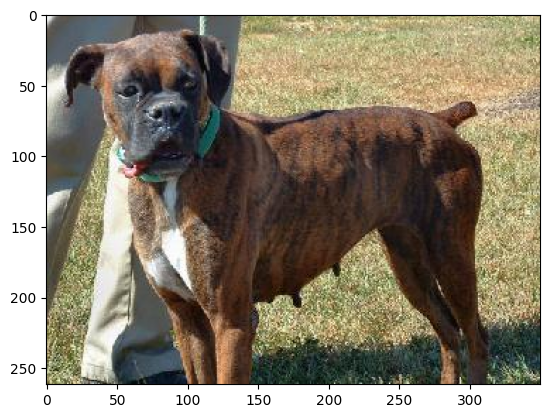

In [7]:
# make sure it's in RGB mode
def load_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = load_image('./data/PetImages/Dog/10396.jpg')
print(img)
plt.imshow(img)
plt.show()

We also need a range of transformations to:
- bring the image to the right dimensions
- convert the image to a tensor 
- normalise it according to the ImageNet receipe.

[Inception V3](https://pytorch.org/hub/pytorch_vision_inception_v3/) expects the size of the images to be 299x299 pixels, as well as normalised to ```mean = [0.485, 0.456, 0.406]``` and ```std = [0.229, 0.224, 0.225]```.

Because we use the LIME package later, we split this into two aspects: The general resizing and cropping that can also be applied to the NumPy-style presentation, and then the part that is specific to PyTorch and the model.

In [8]:
transf_size = tv.transforms.Compose([
        tv.transforms.Resize((299, 299)),
        tv.transforms.CenterCrop(299)
    ])    


transf_norm =transf = tv.transforms.Compose([
        tv. transforms.ToTensor(),
        tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])   
    ])    

Since PyTorch does not provide a convenient "Scikit-Learn"-style prediction method, we need to create one in the format that LIME expects, in particular for the use with the [explain_instance](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance) method.

The method needs to take a 3-dimensional RGB image as input and return a set of probabilities for each class in the same style as ```predict_proba()``` in Scikit-Learn.

The model in PyTorch assumes that the images are passed in batches (as we would normally train or get predictions for batches of images). However, here we pass a single image for which we want to get a local explanation. Therefore, we need to convert this into a batch format that is expected by the model. We assume here that ```images``` is a list-style object that we can convert.

Furthermore, the PyTorch model expects the image data in tensor format, wheras the LIME package expects the image data in NumPy format. Therefore, we need to transform the image to a tensor and also normalise it to the values expected by the model.

We assume here that we have defined the instance of the model (called ```model```) here elsewhere, as we cannot pass this as an argument.
In PyTorch, we also need to move both the data and the model to the device we're using (either CPU or GPU). Therefore, we include this query locally in the function as we cannot pass this information as argument either.

To mimic the behaviour of ```predict_proba()```, we let the model predict the ouptut for each of the classes. Then we use [SoftMax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) to convert this into probabilities for each class. We also need to ```detach()``` these from the computational graph, move them to the CPU (so we can work with them), and convert them to NumPy format for the use with the LIME package.

In [9]:
def predict(images):

    # put model in evaluation mode
    # need to assume that this variable has been defined
    model.eval()
    batch = torch.stack(tuple(transf_norm(i) for i in images), dim=0)

    # make sure "device" exists locally and is correct
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

To make sure that things work, we create a test prediction for our image.
We resize and crop the image, and also pass the image as a list (indicated by ```[ ...]```, because we need to transform this into a batch for the later processing of the image by the PyTorch model.

As described above, the ```predict``` method returns a ```predict_proba``` style output, i.e. a list in which each class is represented with its probability.

We can use ```np.max()``` to find the highest probability, and ```np.argmax()``` to determine which element this corresponds to.
Then we can use the look-up table ```index2label``` to convert this into human-readable form.


In [10]:
test_pred = predict([transf_size(img)])
print('Most likely class: {0} with probability {1:.3f}'.format(index2label[np.argmax(test_pred)], np.max(test_pred)))


Most likely class: boxer with probability 0.996


# Local Explanation

We are now ready to use the [LIME](https://github.com/marcotcr/lime) package. In particular, we use the [LimeImageExplainer](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=LimeImageExplainer#lime.lime_image.LimeImageExplainer) to generate a local explanation of which parts of the image were important in generating the classfiication output. This is done by the 
[explain_instance](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance) method.

The method expects:
- the 3D RGB image as input (i.e. we convert it to a NumPy array here)
- the classifier that takes the NumPy array and produces probabilities in the style of ```predict_proba()``` in Scikit-Learn
- ```top_labels```: predict explanations for the top $n$ prediction outcomes
- ```num_samples```: Details about how to generate the local linear explainable model. A good value is ```num_samples=1000```.

In [15]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(transf_size(img)), 
                                         predict, 
                                         top_labels=5, 
                                         num_samples=100)

100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


We can now look at the image and overlay the regions which are most important for the classification result.
This is done by producing an image mask, that can be overlaid onto the image using the function ```mark_boundaries``` from the scikit-learn package.

In a first step, we only look at the features (or parts) that pushed the model into classifying the image as it did: ```positive_only=True```.

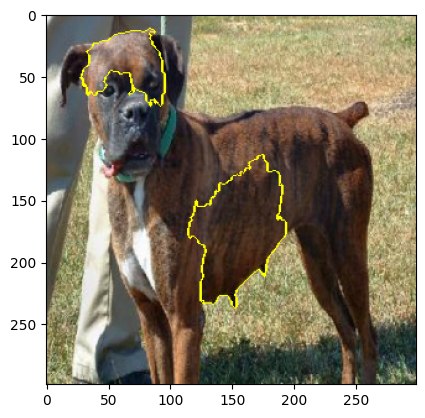

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp / 255 , mask)
plt.imshow(img_boundry1)
plt.show()

In the next step, we also include the top features (regions) that would work against this classification ```positive_only=False```.

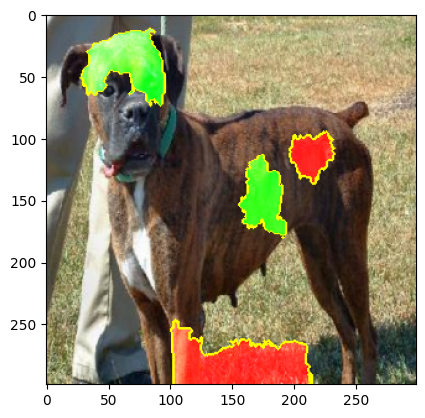

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.show()

Following the example in the [LIME](https://github.com/marcotcr/lime) documentation, we can also express this as a heatmap across the entire image to identify which regions have contributed positively (in blue) and negatively (in red) to the image classification result.

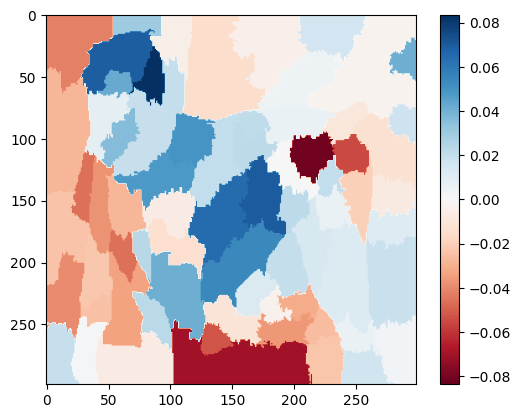

In [18]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()